# 4-2.2

# Only need to execute this notebook in kaggle 
I will train the model, generate the prediction, then save the output as submission.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gc   # garbage collector for cleaning deleted data from memory

img_size = 250
batch_size = 64 # set the batch size of the train and validation data
# channels = 3  # change to 1 if need to use grayscale image

# Load in the training array and label
I have to up load them to the input section of kaggle notebook first

In [2]:
# load the training set
X_TRAIN = np.load("/kaggle/input/msbayvonnehw4/training_X.npy", allow_pickle = True)
y_TRAIN = np.load("/kaggle/input/msbayvonnehw4/training_y.npy", allow_pickle = True)

print("shape of train images:", X_TRAIN.shape)
print("shape of labels:", y_TRAIN.shape)

shape of train images: (25000, 250, 250, 3)
shape of labels: (25000,)


In [3]:
# split the data into train and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_TRAIN, test_size=0.20, random_state=42)

print("shape of train images:", X_train.shape)
print("shape of validation images:", X_val.shape)
print("shape of labels:", y_train.shape)
print("shape of labels:", y_val.shape)

shape of train images: (20000, 250, 250, 3)
shape of validation images: (5000, 250, 250, 3)
shape of labels: (20000,)
shape of labels: (5000,)


In [4]:
# clear memory
del X_TRAIN
del y_TRAIN
gc.collect()

240

# Image augmentation

In [5]:
# image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# this would helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale = 1./255,   # scale the image between 0 and 1
                                   rotation_range = 80,
                                   width_shift_range = 1.0,
                                   height_shift_range = 1.0,
                                   shear_range = 0.8,
                                   zoom_range = [0.1, 2.0],
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='nearest')

# do not augment validation data but only perform rescale
val_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
# create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# record the length of training and validation sets
len_X_train = len(X_train)
len_X_val = len(X_val)

# delete unused variables
del train_datagen
del val_datagen
del y_train
del y_val
del X_train
del X_val
gc.collect()

0

# Import modules for model training

In [7]:
# !pip install --upgrade --user h5py # I use this so solve the tensorflow problem

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D

# Self-built CNN

In [ ]:
# define the model

def creat_model():
    
    model = keras.models.Sequential()

    # data_format='channels_last': so the channels(1 for grayscale/3 for RGB) will be the last dimension in input_shape
    # X_train should be: (batch_size, height, width, channels)
    # i.e., (training_data.shape[0], img_size, img_size, 1) 
    # we have 25000 data

    # convolutional layer 1
    model.add(Conv2D(filters=32, kernel_size=3, data_format='channels_last', input_shape=(img_size, img_size, 3), padding='same', strides=1)) # filters=32: have 32 filters
    model.add(BatchNormalization())
    model.add(Activation("leaky_relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 2
    # after the 1st layer, don't need to specify the size of the input
    model.add(Conv2D(filters=64, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("leaky_relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # convolutional layer 3
    # after the 1st layer, don't need to specify the size of the input
    model.add(Conv2D(filters=128, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("leaky_relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # convolutional layer 4
    # after the 1st layer, don't need to specify the size of the input
    model.add(Conv2D(filters=256, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("leaky_relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # flatten layer
    model.add(Flatten())

    # dense layer 1
    model.add(Dense(units=256))
    model.add(BatchNormalization())
    model.add(Activation("leaky_relu"))
    model.add(Dropout(0.5))
    
    # dense layer 2
    model.add(Dense(units=128))
    model.add(BatchNormalization())
    model.add(Activation("leaky_relu"))
    model.add(Dropout(0.5))
    
    # dense layer 3
    model.add(Dense(units=64))
    model.add(BatchNormalization())
    model.add(Activation("leaky_relu"))
    model.add(Dropout(0.5))
    
    # dense layer 4
    model.add(Dense(units=32))
    model.add(BatchNormalization())
    model.add(Activation("leaky_relu"))
    model.add(Dropout(0.5))

    # output layer (size=1 for regression, since we actually need to generate the probability)
    model.add(Dense(units=1, activation='sigmoid')) # use sigmoid since the probability should falls in [0, 1]

    # compile
    model.compile(loss='binary_crossentropy', optimizer="nadam", metrics=['acc'])
    
    return model

In [ ]:
# creat_model() will return a cnn model initial structure
model = creat_model() 

history = model.fit_generator(train_generator,
                              steps_per_epoch=len_X_train // batch_size,
                              epochs=60,
                              validation_data=val_generator,
                              validation_steps=len_X_val // batch_size)

In [ ]:
# save the entire model as a `.keras` zip archive
model.save('/kaggle/working/my_model.keras')

After trying several tuning for self-built CNN, it still perfoms not good, with loss around 1.9.  
So I turn to pretrained models done by tensorflow.keras.applications.  

# Pretrained keras ResNet50 model

I choose the pretrained model to test from: https://keras.io/api/applications/#usage-examples-for-image-classification-models  
And I found ResNet101V2 performs better in lower loss.  

In [1]:
from tensorflow.keras.applications import ResNet101V2

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [10]:
# build the ResNet101V2 model
img_size = 250
pretrained_model = ResNet101V2(include_top = False, weights = 'imagenet', input_shape=(img_size, img_size, 3))

for layer in pretrained_model.layers:
    layer.trainable = True

# can fine-tune it by passing trainable = True to hub.KerasLayer

171317808/171317808 [==============================] - 1s 0us/step


In [11]:
# build the entire model

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

x = Dense(32, activation='relu')(x) 
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x) 
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x) 
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x) 
x = Dropout(0.7)(x)

x = Dense(512, activation='relu')(x) 
x = Dropout(0.7)(x)

x = Dense(256, activation='relu')(x) 
x = Dropout(0.7)(x)

x = Dense(128, activation='relu')(x) 
x = Dropout(0.5)(x)

x = Dense(64, activation='relu')(x) 
x = Dropout(0.5)(x)

x = Dense(32, activation='relu')(x) 
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs = pretrained_model.input, outputs = predictions)

In [12]:
# define the early stopping callback

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

### I set the early stopping and it will help me control overfitting problem.  

In [13]:
# define training function

def creat_pretrained_model(model, epochs, initial_epoch, optimizer):
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["binary_crossentropy"])
    return model.fit(train_generator, 
                     validation_data=val_generator, 
                     epochs=epochs, 
                     initial_epoch = initial_epoch, 
                     steps_per_epoch = len_X_train // batch_size,
                     validation_steps = len_X_val // batch_size,
                     callbacks=[early_stopping])

In [14]:
# launch the training
history = creat_pretrained_model(model = model, 
                                 epochs = 30, 
                                 initial_epoch = 7, 
                                 optimizer = "nadam")

Epoch 8/30
312/312 [==============================] - 468s 1s/step - loss: 0.6992 - binary_crossentropy: 0.6992 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 9/30
312/312 [==============================] - 355s 1s/step - loss: 0.6936 - binary_crossentropy: 0.6936 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 10/30
312/312 [==============================] - 354s 1s/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6932 - val_binary_crossentropy: 0.6932
Epoch 11/30
312/312 [==============================] - 357s 1s/step - loss: 0.6934 - binary_crossentropy: 0.6934 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933
Epoch 12/30
312/312 [==============================] - 356s 1s/step - loss: 0.6935 - binary_crossentropy: 0.6935 - val_loss: 0.6933 - val_binary_crossentropy: 0.6933


# Visualize training and validation loss

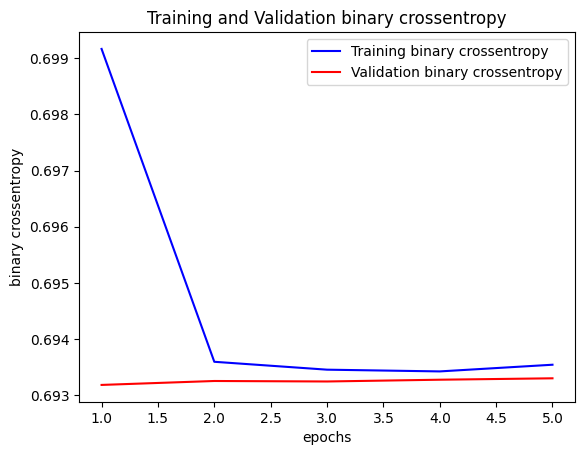

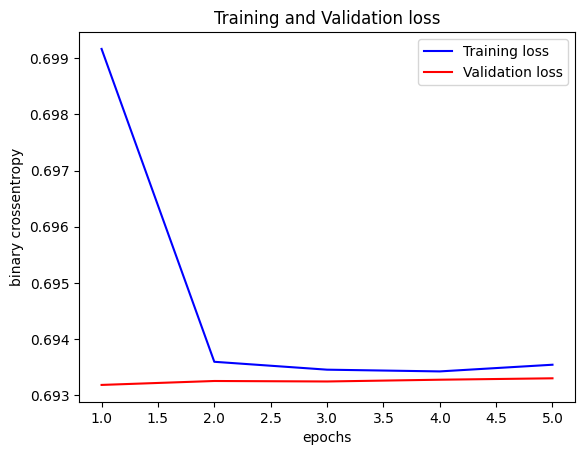

In [15]:
# plot the train and val curve

binary_crossentropy = history.history['binary_crossentropy']
val_binary_crossentropy = history.history['val_binary_crossentropy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(binary_crossentropy) + 1)

#Train and validation accuracy
plt.plot(epochs, binary_crossentropy, 'b', label='Training binary crossentropy')
plt.plot(epochs, val_binary_crossentropy, 'r', label='Validation binary crossentropy')
plt.title('Training and Validation binary crossentropy')
plt.xlabel('epochs')
plt.ylabel('binary crossentropy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epochs')
plt.ylabel('binary crossentropy')
plt.legend()

plt.show()

# Summary for model training
Loss in training set decrease rapidly yet slowly in validation set, and training phase was interrupted by early stopping with the hyperparameter patience = 5.  
And also note that I only use epochs from 8 to 30 by setting initial_epoch to get more stable outcome.  

# Save the model

In [16]:
# save the entire model as a `.keras` zip archive
model.save('/kaggle/working/1202_ResNet101V2_7-30_earlystop_epochs.keras')

# Do prediciton on testing set
I execute this section whenever a model is trained and generate a submission.csv

In [2]:
# reload the trained model before doing prediction
import tensorflow as tf

reloaded_model = tf.keras.models.load_model('/kaggle/working/1202_ResNet101V2_7-30_earlystop_epochs.keras')

# show the model architecture
reloaded_model.summary()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 125, 125, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 127, 127, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [4]:
# load the testing set
X_test = np.load("/kaggle/input/msbayvonnehw4/testing_X.npy", allow_pickle = True)

# convert to array
X_test = np.array(X_test)

# check the shape
X_test.shape

(12500, 250, 250, 3)

In [5]:
# image augmentaion (just rescaling)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test)

# delete unused variables
del X_test
del test_datagen
gc.collect()

# do prediction
outcome = reloaded_model.predict(test_generator)

391/391 [==============================] - 52s 115ms/step


### Now let's build the dataframe to save as a csv file

In [6]:
# generate a DataFrame
id = np.array(range(1, 12501))
result = pd.DataFrame(outcome, columns=['label'])
result.insert(0, 'id', id)
result.head(5)

,id,label
0,1,0.501300
1,2,0.501299
2,3,0.501298
3,4,0.501300
4,5,0.501300


In [7]:
# save the DataFrame to a csv file
result.to_csv('/kaggle/working/MSBA.Session2.WeiChunChang.csv', index=False)
# 1202_ResNet101V2_7-30_earlystop_epochs

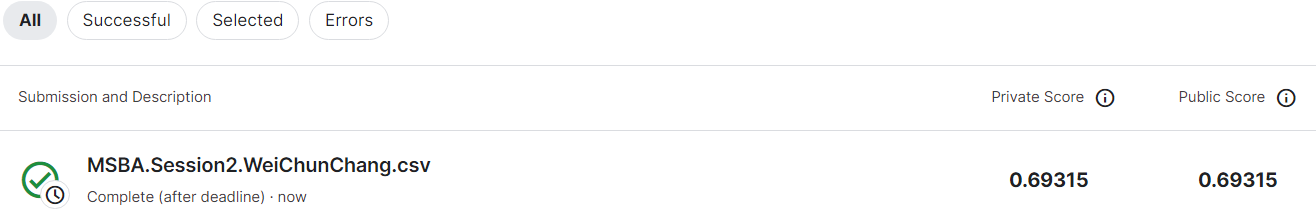

This is the grade I get in the end, much better than 1.9 using self-built CNN.  

# This is the end of the notebook